In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import pandas as pd

import os
import sys

# Get the current directory
current_dir = os.path.dirname(os.path.abspath('__file__'))

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)
sys.path.append(os.path.join(parent_dir, 'turning_scripts'))

from data_preambles import dtypes_no_id, col_names, csv_to_exclude, catalog_col_names
from path_prefix import PATH_PREFIX



In [3]:
# Load one CSV file
hour_df = pd.read_csv(f'{PATH_PREFIX}/data/csv/1716508800.csv', dtype=dtypes_no_id, parse_dates=True)
hour_df.columns = col_names
hour_df.head(5)
# Add an id column
hour_df['id'] = hour_df['icao24'] + hour_df['callsign']
hour_df.head(5)


,time,icao24,lat,lon,heading,callsign,geoaltitude,id
0,1716509939,347247,37.569099,6.185840,287.154069,IBS3627,10728.96,347247IBS3627
1,1716509999,347247,37.610413,6.017937,287.163866,IBS3627,10721.34,347247IBS3627
2,1716510179,347247,37.711029,5.604488,286.886791,IBS3627,10713.72,347247IBS3627
3,1716511439,4bb187,50.043640,19.430550,321.357708,THY184,10576.56,4bb187THY184
4,1716511619,4bb187,50.373642,19.017479,321.058988,THY184,10576.56,4bb187THY184


In [4]:
hour_ids = hour_df['id'].unique()
print(f'There are {len(hour_ids)} unique ids in the hour_df')

There are 996 unique ids in the hour_df


In [5]:
from get_turns import get_turning_points, TurnAndRise
from collections import deque
from tqdm import tqdm

# Note that get_turning_points will automatically add the first and last point to the list of turning points
# So we don't need to add them manually

In [14]:
# For each callsign, we attempt to get the turning points
print('Creating segments...')
print('Caution: will skip N/A rows')

seg_from_lat = deque()
seg_from_lon = deque()
seg_to_lat = deque()
seg_to_lon = deque()

callsigns_skipped = 0
for id in tqdm(hour_ids):
    try:
        df_id = hour_df[hour_df['id'] == id]
        tr = get_turning_points(df_id)
    except ValueError as e:
        # print(f'Skipping {id} because {e}')
        callsigns_skipped += 1
        continue

    # For each turn, we get the segment from and to
    for i in range(len(tr['tp_time']) - 1):
        seg_from_lat.append(tr['tp_lat'][i])
        seg_from_lon.append(tr['tp_lon'][i])
        seg_to_lat.append(tr['tp_lat'][i+1])
        seg_to_lon.append(tr['tp_lon'][i+1])

print(f'There were {len(hour_ids)} callsigns, of which {callsigns_skipped} were skipped')
    

Creating segments...
Caution: will skip N/A rows


  0%|          | 0/996 [00:00<?, ?it/s]

100%|██████████| 996/996 [00:23<00:00, 43.09it/s]

There were 996 callsigns, of which 122 were skipped


In [19]:
from datetime import datetime, timezone

timestamp = 1716508800

# Convert timestamp to datetime object in UTC
utc_datetime = datetime.fromtimestamp(timestamp, tz=timezone.utc)

# Format the datetime as a string
formatted_datetime = utc_datetime.strftime("%Y-%m-%d %H:%M:%S %Z")

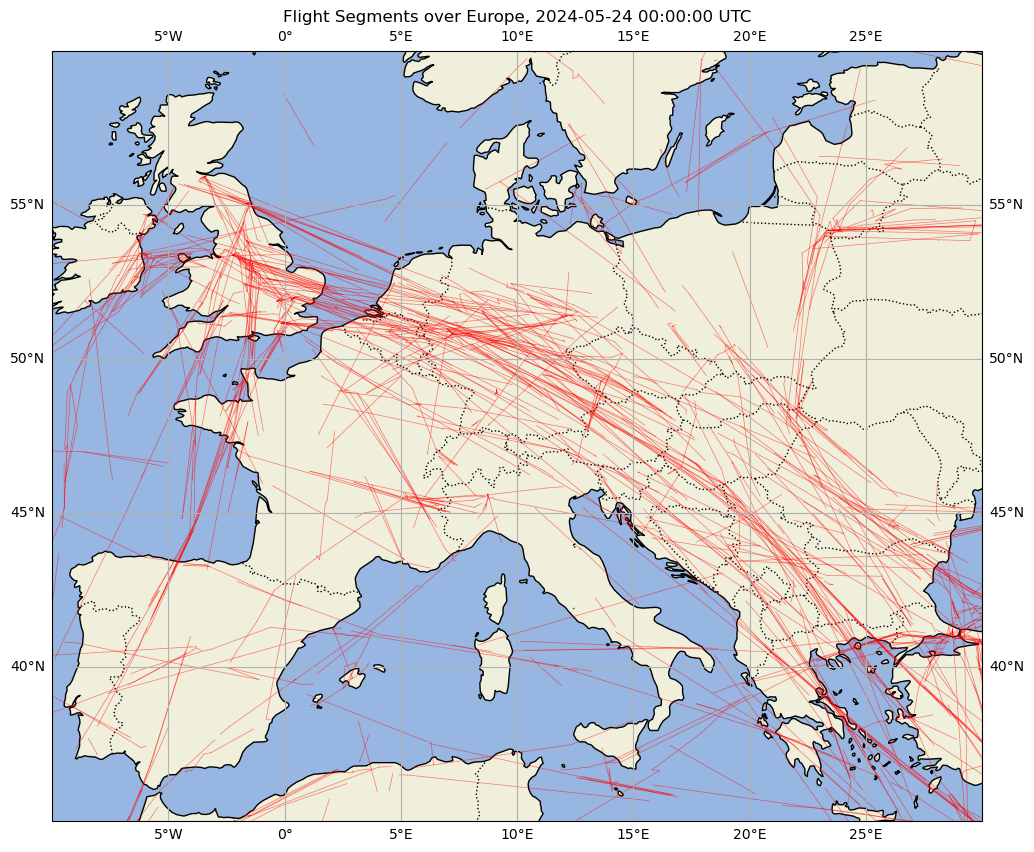

In [22]:
# Plot all the segments on a map

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a new figure and axis with a map projection
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_aspect('auto')  # This allows the aspect ratio to adjust naturally

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the extent of the map to cover Europe
ax.set_extent([-10, 30, 35, 60], crs=ccrs.PlateCarree())

# Plot the segments
for from_lat, from_lon, to_lat, to_lon in zip(seg_from_lat, seg_from_lon, seg_to_lat, seg_to_lon):
    ax.plot([from_lon, to_lon], [from_lat, to_lat], 
            color='red', linewidth=0.5, alpha=0.5, 
            transform=ccrs.Geodetic())

# Add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Add a title
plt.title(f'Flight Segments over Europe, {formatted_datetime}')

# Show the plot
plt.show()
# Create a directory for the plots if it doesn't exist
# os.makedirs(f'{PATH_PREFIX}/data/plots', exist_ok=True)
# plt.savefig(f'{PATH_PREFIX}/data/plots/flight_segments_{timestamp}.png')